# Neural networks models Baseline

In this notebook we will describe 3 uses case that will function as our baseline models to our investigations <br>

In [1]:
import os
import math
import random 
import pandas as pd #data manipulation
import numpy as np # linear algebra
import matplotlib.pyplot as plt #plotting
import seaborn as sns #statistic graphics plotting
import cv2 #opencv
import torch # if neural networks
from torch import nn
import torch.nn.functional as F
import torchvision #cnn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms 
from torch import optim
from PIL import Image
import gc #garbage collector
from tqdm import tqdm #progress meter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error,accuracy_score

# Regression task

The function to regress is (x1 - x2) + (x3 * x3)

In [2]:
regression_df = pd.read_csv('./data/csv/regression.csv')
print(len(regression_df))
regression_df.head()


999


x1  x2  x3    y  class
0  -4  -6  -9   83      1
1   9   6  -1    4      1
2  -1 -10   3   18      1
3  -2  10   0  -12      0
4   1   0 -10  101      1

In [3]:
features = ['x1','x2','x3']
x = regression_df[features]
y = regression_df.y
train_x,eval_x,train_y,eval_y = train_test_split(x,y,train_size = 0.8,random_state = 3)

In [4]:
torch.tensor(train_x.values).shape

torch.Size([799, 3])

In [5]:
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor,self).__init__()
        self.fc1 = nn.Linear(3,3)
        self.out = nn.Linear(3,1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x


        

In [6]:
def ovefititing_training(model,loss_function,optimizer,input_data,output_data,max_epochs=20):
    '''Train the model for one wimple input until overfit 
   the number of pass required will then the epochs(the time of passed for all the training set) '''
    running_loss = 0
    accuracy = 0
    input_indx = random.randint(0,len(input_data))
    for epoch in tqdm(range(max_epochs)):
        model.train()
        #get data
        input_tensor = torch.tensor(input_data.values[input_indx],dtype = torch.float32)#dataframe rec
        output_tensor = torch.tensor(output_data.values[input_indx],dtype = torch.float32)
        #move to device
        input_tensor = input_tensor.to(device)
        output_tensor =  output_tensor.to(device)
        output_tensor = output_tensor[None][None]#adjust to output size
        #clean gradients
        optimizer.zero_grad()
        prediction = model(input_tensor[None])#same as unsqueeze(input_tensor,x)
       # print(prediction.shape,prediction,output_tensor.shape,output_tensor)
        loss = loss_function(prediction,output_tensor)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('loss',running_loss)
          
    #model evaluation
    model.eval()
    with torch.no_grad():
        #get data
        input_tensor = torch.tensor(input_data.values[input_indx],dtype = torch.float32)#dataframe rec
        #output_tensor = torch.tensor(output_data.values[input_indx],dtype = torch.float32)
        #move to device
        input_tensor = input_tensor.to(device)
        prediction = model(input_tensor[None])#same as unzquezee 
        prediction_num = prediction.data.cpu().numpy()
        print('x:',input_data.values[input_indx],'y:',output_data.values[input_indx])
        print('Model output ý:',prediction_num, 'Expected output y :', output_data.values[input_indx])
        
        
        
        
       


In [7]:
def train_model(model,loss_function,optimizer,input_data,output_data,max_epochs=20):
    '''Train for all the dataset without early stopping batch size 1'''
    running_loss = 0
    accuracy = 0
    data_len = len(input_data)
    for epoch in tqdm(range(max_epochs)):
        model.train()
        #running_loss = 0
        for indx in range(data_len):
            #get data
            input_tensor = torch.tensor(input_data.values[indx],dtype = torch.float32)#dataframe rec
            output_tensor = torch.tensor(output_data.values[indx],dtype = torch.float32)
            #move to device
            input_tensor = input_tensor.to(device)
            output_tensor =  output_tensor.to(device)
            output_tensor = output_tensor[None][None]#adjust to output size
            #clean gradients
            optimizer.zero_grad()
            prediction = model(input_tensor[None])#same as unsqueeze(input_tensor,x)
            
            loss = loss_function(prediction,output_tensor)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    print('epoch',epoch, 'running_loss',running_loss)
    #save the model
    torch.save(model.state_dict(), './model_zoo/regressor.pth')
    print('...model save')
      
    #model evaluation
def eval_model(model,input_data,output_data):
    model.eval()
    output_a =[] 
    data_len = len(input_data)
    with torch.no_grad():
        
        for indx in tqdm(range(data_len)):
            #get data
            input_tensor = torch.tensor(input_data.values[indx],dtype = torch.float32)#dataframe rec
            
            #output_tensor = torch.tensor(output_data.values[input_indx],dtype = torch.float32)
            #move to device
            input_tensor = input_tensor.to(device)
            output = model(input_tensor[None])#same as unzquezee
            #print(input_tensor,output,output_data.values[input_indx])
            output_num = output.data.cpu().numpy()   
            output_a.append(output_num.item())
    input_indx = random.randint(0,data_len)
    print('x:',input_data.values[input_indx],'y:',output_data.values[input_indx])
    print('Sample Model output ý:',output_a[input_indx], 'Expected output y :', output_data.values[input_indx])
    return np.array(output_a)

In [8]:
regressor = Regressor()
MSE_criterion = nn.MSELoss()
adam_optimizer = optim.Adam(regressor.parameters(), lr=0.001)
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regressor.to(device)

Regressor(
  (fc1): Linear(in_features=3, out_features=3, bias=True)
  (out): Linear(in_features=3, out_features=1, bias=True)
)

In [17]:
nEpochs = 1000
torch.cuda.empty_cache()
ovefititing_training(regressor,MSE_criterion,adam_optimizer,train_x,train_y,nEpochs)

100%|██████████| 1000/1000 [00:01<00:00, 849.59it/s]

loss 0.0006788627811680215
x: [ 0.3 -0.2  0.8] y: 0.5847457627118644
Model output ý: [[69.]] Expected output y : 69.0


In [9]:
nEpochs = 500
torch.cuda.empty_cache()
train_model(regressor,MSE_criterion,adam_optimizer,train_x,train_y,nEpochs)

100%|██████████| 500/500 [08:03<00:00,  1.03it/s]

epoch 499 running_loss 23383767.814886138
...model save


In [10]:
torch.cuda.empty_cache()
predictions = eval_model(regressor,eval_x,eval_y)
eval_y_np = np.array(eval_y.values)

for indx in range(len(eval_y_np)):
    print(eval_y_np[indx],predictions[indx])
    
d = np.abs(eval_y_np - predictions)
s = np.abs(eval_y_np) + np.abs(predictions)
print("mean difference",np.mean(d))

100%|██████████| 200/200 [00:00<00:00, 4388.38it/s]

x: [-3  6  1] y: -8
Sample Model output ý: -9.644865989685059 Expected output y : -8
65 67.77967834472656
83 83.2955322265625
26 19.867786407470703
52 56.89667510986328
86 84.543212890625
81 81.84440612792969
113 104.92738342285156
70 72.0879898071289
75 77.35819244384766
17 11.292550086975098
96 92.35443878173828
35 29.20751190185547
51 50.89091873168945
7 -2.673933982849121
104 96.41596984863281
57 59.25495147705078
18 17.851055145263672
32 37.33789825439453
6 5.407341003417969
-1 2.5944032669067383
115 106.81021118164062
70 71.56486511230469
48 48.80179977416992
65 66.28047943115234
12 15.006400108337402
25 24.600727081298828
5 -0.4171628952026367
27 26.711612701416016
9 3.677196502685547
74 74.7601318359375
43 47.77082061767578
55 56.060447692871094
46 44.90902328491211
-4 -3.675820827484131
111 103.01554870605469
43 47.8868408203125
38 34.33985900878906
-1 1.2537755966186523
4 -2.0750417709350586
10 9.749375343322754
7 7.265133857727051
17 19.356857299804688
62 65.05210876464844
1

## Conclusions

Data is most important than architecture in NN, you have to provided enough data to cover most of the search space , In first try we tried to approximate the function with a real deep network but only 100 data entries,but failed to converge, it was possible to overfit over one sample in only 100 pass with a single layer NN

Second try 1000 entried with a shallow network  improve the accuracy greatly
MSELoss best results but it didnt predict a single correct result,  
best result with shallow architecture
best run withh leranign rate .001 an only one hiden layer no dropout

# Classification task 

From the previous example ( (x1 - x2) + (x3 * x3) )<br>
we will classify the result ,if the number is positve(1) or negative(0), we will make the classification from the inputs, so we will add a sigmoid function to the network and change the loss function and target 




In [23]:
classification_df = pd.read_csv('./data/csv/regression.csv')
print(len(classification_df))
classification_df.head()


999


x1  x2  x3    y  class
0  -4  -6  -9   83      1
1   9   6  -1    4      1
2  -1 -10   3   18      1
3  -2  10   0  -12      0
4   1   0 -10  101      1

In [25]:
features_class = ['x1','x2','x3']
x_class = classification_df[features_class]
y_class = classification_df['class']
train_x_class,eval_x_class,train_y_class,eval_y_class = train_test_split(x_class,y_class,train_size = 0.8,random_state = 3)

In [26]:
class Classificator(nn.Module):
    def __init__(self):
        super(Classificator,self).__init__()
        self.fc1 = nn.Linear(3,3)
        self.out = nn.Linear(3,2)
    
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.out(x),dim =1)
        return x


        

In [27]:
def ovefititing_training_class(model,loss_function,optimizer,input_data,output_data,max_epochs=20):
    '''Train the model for one wimple input until overfit 
   the number of pass required will then the epochs(the time of passed for all the training set) '''
    running_loss = 0
    accuracy = 0
    input_indx = random.randint(0,len(input_data))
    for epoch in tqdm(range(max_epochs)):
        model.train()
        #get data
        input_tensor = torch.tensor(input_data.values[input_indx],dtype = torch.float32)#dataframe rec
        output_tensor = torch.tensor(output_data.values[input_indx])
        #move to device
        input_tensor = input_tensor.to(device)
        output_tensor =  output_tensor.to(device)
        output_tensor = output_tensor[None]#adjust to output size
        #clean gradients
        optimizer.zero_grad()
        prediction = model(input_tensor[None])#same as unsqueeze(input_tensor,x)
      #  print(prediction.shape,prediction,output_tensor.shape,output_tensor)
        loss = loss_function(prediction,output_tensor)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('loss',running_loss)
          
    #model evaluation
    model.eval()
    with torch.no_grad():
        #get data
        input_tensor = torch.tensor(input_data.values[input_indx],dtype = torch.float32)#dataframe rec
        #output_tensor = torch.tensor(output_data.values[input_indx],dtype = torch.float32)
        #move to device
        input_tensor = input_tensor.to(device)
        prediction = model(input_tensor[None])#same as unzquezee 
        probabilities = torch.exp(prediction)
        value,class_pred = torch.max(probabilities,1)
        #prediction_num = prediction.data.cpu().numpy()
        print('x:',input_data.values[input_indx],'y:',output_data.values[input_indx])
        print('Model output ý:',prediction, 'Probabilitiess',probabilities, 'class prediction',class_pred,'Expected output y :', output_data.values[input_indx])
        
        
        
        
       


In [28]:
def train_model_class(model,loss_function,optimizer,input_data,output_data,max_epochs=20):
    '''Train for all the dataset without early stopping batch size 1'''
    running_loss = 0
    accuracy = 0
    data_len = len(input_data)
    for epoch in tqdm(range(max_epochs)):
        model.train()
        #running_loss = 0
        for indx in range(data_len):
            #get data
            input_tensor = torch.tensor(input_data.values[indx],dtype = torch.float32)#dataframe rec
            output_tensor = torch.tensor(output_data.values[indx])
            #move to device
            input_tensor = input_tensor.to(device)
            output_tensor =  output_tensor.to(device)
            output_tensor = output_tensor[None]#adjust to output size
            #clean gradients
            optimizer.zero_grad()
            prediction = model(input_tensor[None])#same as unsqueeze(input_tensor,x)  
            loss = loss_function(prediction,output_tensor)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    print('epoch',epoch, 'running_loss',running_loss)
    #save the model
    torch.save(model.state_dict(), './model_zoo/classifier.pth')
    print('...model save')
      
    #model evaluation
def eval_model_class(model,input_data,output_data):
    model.eval()
    output_a =[] 
    data_len = len(input_data)
    with torch.no_grad():
        
        for indx in tqdm(range(data_len)):
            #get data
            input_tensor = torch.tensor(input_data.values[indx],dtype = torch.float32)#dataframe rec
            
            #output_tensor = torch.tensor(output_data.values[input_indx],dtype = torch.float32)
            #move to device
            input_tensor = input_tensor.to(device)
            output = model(input_tensor[None])#same as unzquezee
            #print(input_tensor,output,output_data.values[input_indx])
            prediction = model(input_tensor[None])#same as unzquezee 
            probabilities = torch.exp(prediction)
            value,class_pred = torch.max(probabilities,1)
            class_np = class_pred.data.cpu().numpy()
            output_a.append(class_np.item())
    input_indx = random.randint(0,data_len)
    print('x:',input_data.values[input_indx],'y:',output_data.values[input_indx])
    print('Sample Model output ý:',output_a[input_indx], 'Expected output y :', output_data.values[input_indx])
    return np.array(output_a)

In [29]:

classificator = Classificator()
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classificator.to(device)

Cross_criterion = nn.NLLLoss()
SGD_optimizer = torch.optim.SGD(classificator.parameters(), lr=0.01)

In [30]:
nEpochs = 1000
torch.cuda.empty_cache()
ovefititing_training_class(classificator,Cross_criterion,SGD_optimizer,train_x_class,train_y_class,nEpochs)

100%|██████████| 1000/1000 [00:00<00:00, 1327.32it/s]

loss 152.4910587668419
x: [-7 -9 -7] y: 1
Model output ý: tensor([[-2.9820, -0.0520]], device='cuda:0') Probabilitiess tensor([[0.0507, 0.9493]], device='cuda:0') class prediction tensor([1], device='cuda:0') Expected output y : 1


In [10]:
nEpochs = 500
torch.cuda.empty_cache()
train_model_class(classificator,Cross_criterion,SGD_optimizer,train_x_class,train_y_class,nEpochs)

100%|██████████| 500/500 [07:26<00:00,  1.12it/s]

epoch 499 running_loss 8579.196782326326
...model save


In [11]:
torch.cuda.empty_cache()
predictions = eval_model_class(classificator,eval_x_class,eval_y_class)
eval_y_np = np.array(eval_y_class.values)
print(eval_y_np)
print(predictions)
d = np.abs(eval_y_np) - np.abs(predictions)
s = np.abs(eval_y_np) + np.abs(predictions)
print("mean difference",np.mean(d))

100%|██████████| 200/200 [00:00<00:00, 3089.70it/s]

x: [ 0  3 -6] y: 1
Sample Model output ý: 1 Expected output y : 1
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0
 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0
 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1]
mean difference 0.0


# Conclussion
Classification is an easier task for NN with better accuracy with the same model as regressor

# Image segmentation and identification 

we will generate 200 images containing a square, a circle or both in different amount of quantitie
and we will provide the required masks<br>
The NN will have to identify in one channel the square and the circle in the other<br>2
We will use the encoder-decoder-residual architecture by UNet for the task



In [2]:
mask_path_rect = './data/img/masks/rectangles/'
mask_path_circ = './data/img/masks/circles/'
img_path =  './data/img/images/'


In [3]:
nMaxRadio = 45
nMaxSideSize = 60
nImageSize = 256
def generate_images(img_path,mask_path_rect,mask_path_circ,number_imgs = 100):
    for indx in tqdm(range(number_imgs)):
        img_rect = np.zeros((nImageSize,nImageSize,3),np.uint8)
        img_circ = np.zeros((nImageSize,nImageSize,3),np.uint8)
        img_rect_grey = np.zeros((nImageSize,nImageSize),np.uint8)
        img_circ_grey = np.zeros((nImageSize,nImageSize),np.uint8)
        
        #parameter rectangle
        side = random.randint(10,nMaxSideSize)
        up_x = random.randint(0,(nImageSize-2*side))
        up_y = random.randint(0,(nImageSize-2*side))
        bot_x = up_x + side
        bot_y = up_y+ side
        
        #Get the random parameters circle
        radio = random.randint(10,nMaxRadio)
        center_x =  random.randint(radio,(nImageSize-radio))
        center_y =  random.randint(radio,(nImageSize-radio))

        #draw images
        #color in BGR we will invert the positions to mix the colors
        B = random.randint(0,255)
        G = random.randint(0,255)
        R = random.randint(0,255)
        #stroke color in BGR,thickness in px(-1 to fill)
        img_rect =cv2.rectangle(img_rect,(up_x,up_y),(bot_x,bot_y),(B,G,R),-1)
        img_circ = cv2.circle(img_circ,(center_x,center_y),radio,(R,G,B),-1)
        figure =  cv2.addWeighted(img_rect,1, img_circ,1,0.0)#img_rect +img_circ
        cv2.imwrite(img_path+str(indx)+'.png',figure)
        
        #draw masks
        img_rect_grey =cv2.rectangle(img_rect_grey,(up_x,up_y),(bot_x,bot_y),255,-1)
        img_circ_grey = cv2.circle(img_circ_grey,(center_x,center_y),radio,255,-1)
        cv2.imwrite(mask_path_rect+str(indx)+'.png',img_rect_grey)
        cv2.imwrite(mask_path_circ+str(indx)+'.png',img_circ_grey)


In [4]:
#generate_images(img_path,mask_path_rect,mask_path_circ,200)

In [5]:
def get_img(img_path, torch_format = True):
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        #original img.shape =(256,256,3) HxWxC
        #new img.shape =(3,256,256)CxHxW
        if torch_format:
            img = np.moveaxis(img, -1, 0) 
    return img

def get_mask(img_path,crossEntropyClass = 1):
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #drop color informatio for masks
        img = (img/255.0)*crossEntropyClass #to normalize a grey image only divide by 255
    return img 
    

(256, 256, 3)


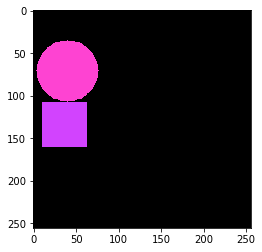

In [9]:
img_1 = get_img(img_path+str(0)+ '.png',False)
print(img_1.shape)
#print(np.argwhere(img_1 >0))
plt.imshow(img_1)

(256, 256)


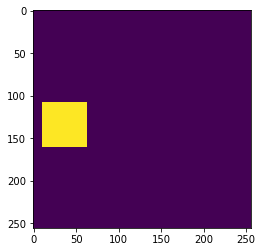

In [11]:
img_1 = get_mask(mask_path_rect+str(0)+ '.png')
print(img_1.shape)
plt.imshow(img_1)

(256, 256)


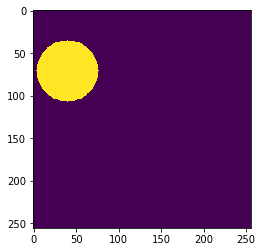

In [12]:
img_1 = get_mask(mask_path_circ+str(0)+ '.png',2)
print(img_1.shape)
#print(np.argwhere(img_1 ==2))
plt.imshow(img_1)

In [13]:
#https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
class FigureDataset(Dataset):
    """Figure dataset."""

    def __init__(self,img_dir, mask_dir_rect, mask_dir_circ, transform=None):
        self.img_dir = img_dir
        self.mask_dir_rect = mask_dir_rect
        self.mask_dir_circ = mask_dir_circ
        self.transform = transform
        
    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Get the labels
        img_name = self.img_dir +str(idx)+ '.png'
        mask_rect_name = self.mask_dir_rect+str(idx)+ '.png'
        mask_circ_name = self.mask_dir_circ+str(idx)+ '.png'
        
        img = get_img(img_name)
        mask_rect = get_mask(mask_rect_name)
        mask_circ =  get_mask(mask_circ_name)#get_mask(mask_circ_name,2)
        return [torch.from_numpy(img),torch.from_numpy(mask_rect), torch.from_numpy(mask_circ)]

In [14]:
train_dataset = FigureDataset(img_path,mask_path_rect,mask_path_circ)

In [15]:
for idx in range(1):
    img,mask_rect ,mask_circ= train_dataset[idx]
    print(img.shape,mask_rect.shape,mask_circ.shape)
    #plt.imshow(mask_rect)

torch.Size([3, 256, 256]) torch.Size([256, 256]) torch.Size([256, 256])


In [16]:
nBatchSize = 1
# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=nBatchSize, shuffle=True,  num_workers=0)
eval_loader =   DataLoader(dataset=train_dataset, batch_size=nBatchSize, shuffle=False, num_workers=0)

In [17]:
for  img,mask_rect ,mask_circ in tqdm(eval_loader):
    pass

100%|██████████| 200/200 [00:00<00:00, 346.82it/s]


In [18]:
#model Unet

In [19]:
#https://github.com/milesial/Pytorch-UNet/
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        #https://pytorch.org/docs/stable/torch.html?highlight=cat#torch.cat
        x = torch.cat([x2, x1], dim=1)
        #print('x Up fordward',x.shape,x1.shape,x2.shape)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        #self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3,padding =1)
        
    def forward(self, x):
            return self.conv(x)

    

In [20]:

#model from #https://github.com/milesial/Pytorch-UNet 

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)  #-->H/16,W/16
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits
    
        

In [21]:
#if crossentropyloss rec = 1, circ = 2
binary_criterion_rec = nn.BCEWithLogitsLoss(reduction='sum')
binary_criterion_circ = nn.BCEWithLogitsLoss(reduction='sum')
def criterion (prediction, rec_mask,circ_mask):
    #first try two logicts losses
    loss_rec =binary_criterion_rec(prediction[:,0],rec_mask)
    loss_circ = binary_criterion_circ(prediction[:,1],circ_mask)
    return loss_rec + loss_circ
            


In [22]:
'''Train the model for one wimple input until overfit 
the number of pass required will then the epochs(the time of passed for all the training set) '''
def ovefititing_training(model,optimizer,dataset,max_epochs=20):
    running_loss = 0
    accuracy = 0
    input_indx =12# random.randint(0,len(dataset))
    torch.cuda.empty_cache()
    for epoch in tqdm(range(max_epochs)):
        model.train()
        img,mask_rect ,mask_circ = dataset[input_indx]
        img = img.to(device)
        mask_rect =  mask_rect.to(device)
        mask_circ = mask_circ.to(device)
        #clean gradients
        optimizer.zero_grad()
        output = model(img[None])#same as unsquesse
        #loss = loss_function_torch(output,encoded_mask[None])
        loss = criterion(output,mask_rect[None] ,mask_circ[None])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('loss',running_loss)
          
    #model evaluation
    model.eval()
    with torch.no_grad():
        img,mask_rect ,mask_circ = dataset[input_indx]
        img = img.to(device)
        output = model(img[None])#same as unzquezee 
        output_num = output.data.cpu().numpy()
        output_bin = output_num[0]
        
        img = img.data.cpu().numpy()
        img = np.moveaxis(img, 0, -1)
        
        plt.figure(figsize=(18,18))
        plt.subplot(311)
        plt.imshow(img)
        plt.subplot(312)
        plt.imshow(output_bin[0])
        plt.subplot(313)
        plt.imshow(output_bin[1])
        
        
       


100%|██████████| 1000/1000 [01:23<00:00, 11.98it/s]


loss 3015637.4920045664


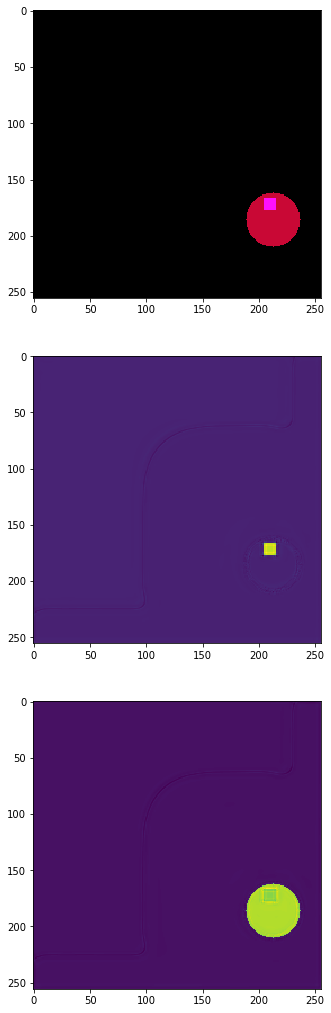

In [24]:
ovefititing_training(unet_model,optimizer_adam,train_dataset,1000)

# Overfitting works well now try  train 200 images 

In [33]:
def train_model_early_stop(model,optimizer,train_loader,eval_loader,epochs = 10, metrics_df=None):
    torch.cuda.empty_cache()
    last_eval_loss = None
    nlossepochs = 3 #if eval loss increment after two epochs break the training
    epochsIncrementLoss = 0
    for epoch in range(epochs):
        model.train()
        #adjust variables
        for batch_idx, (img,mask_rect ,mask_circ) in enumerate(tqdm(train_loader)):
            #move to gpu
            img = img.to(device)
            mask_rect = mask_rect.to(device)
            mask_circ = mask_circ.to(device)
            #clean gradients
            optimizer.zero_grad()
            #fordward
            output = model(img)
            #loss
            loss = criterion(output,mask_rect, mask_circ)
            #backward
            loss.backward()
            #upate weights
            optimizer.step()
            # save metrics
            if metrics_df is not None:
                metrics_df.loc[epoch + batch_idx / len(train_loader), 'train_loss'] = loss.data.cpu().numpy()
            #break if required   
            #if batch_idx > 0:
              #  break
        #Inform the loss       
        print('Train Epoch: {} \tLR: {:.6f}\tLoss: {:.6f}'.format(
            epoch,
            optimizer.state_dict()['param_groups'][0]['lr'],
            loss.item()))
        
        #evaluate model after each epoch
        model.eval()
        eval_loss = 0
        with torch.no_grad():
            for batch_idx,(img,mask_rect ,mask_circ) in enumerate (tqdm(eval_loader)):
                img = img.to(device)
                mask_rect = mask_rect.to(device)
                mask_circ = mask_circ.to(device)
                output = model(img)
                #eval_loss += loss_function_torch(output, encoded_batch, size_average=False).data
                eval_loss += criterion(output,mask_rect, mask_circ).data
                if batch_idx > 20:#we will test with 20images
                    break

        eval_loss /= len(eval_loader.dataset)
        if last_eval_loss and last_eval_loss < eval_loss:
            epochsIncrementLoss+=1
            print("Warning Train loss incrementing")
        else:
            #save the model when the loss 
            epochsIncrementLoss= 0
            print("Saving Model")
            torch.save(model.state_dict(), './model_zoo/image_segmentation.pth')
        #save metrics
            last_eval_loss =eval_loss
        if metrics_df is not None:
            metrics_df.loc[epoch, 'dev_loss'] = eval_loss.cpu().numpy()
        #inform the loss
        print('evaluation loss: {:.4f}'.format(eval_loss))
        # training early stop  
        
        #if epochsIncrementLoss > nlossepochs:
            #break;

In [42]:
#TEST CODE
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#move Model to Device
unet_model = UNet(3,2)
unet_model.to(device)
nEpochs = 15
optimizer_adam = optim.Adam(unet_model.parameters(), lr=0.001)

#metrics of learning
metrics_df = pd.DataFrame()
print(device)

cuda


In [43]:
nEpochs = 50
train_model_early_stop(unet_model,optimizer_adam,train_loader,eval_loader,nEpochs, metrics_df)

  3%|▎         | 6/200 [00:00<00:03, 52.39it/s]

Train Epoch: 0 	LR: 0.001000	Loss: 9143.528051


  0%|          | 0/200 [00:00<?, ?it/s]

Saving Model
evaluation loss: 868.4127


  3%|▎         | 6/200 [00:00<00:03, 52.01it/s]

Train Epoch: 1 	LR: 0.001000	Loss: 1513.413384


  0%|          | 0/200 [00:00<?, ?it/s]

Saving Model
evaluation loss: 665.4722


  3%|▎         | 6/200 [00:00<00:03, 51.88it/s]

Train Epoch: 2 	LR: 0.001000	Loss: 8668.398437


  0%|          | 0/200 [00:00<?, ?it/s]

Saving Model
evaluation loss: 602.4066


  3%|▎         | 6/200 [00:00<00:03, 54.48it/s]

Train Epoch: 3 	LR: 0.001000	Loss: 5226.268504


  0%|          | 0/200 [00:00<?, ?it/s]

Saving Model
evaluation loss: 581.0160


  2%|▎         | 5/200 [00:00<00:04, 45.23it/s]

Train Epoch: 4 	LR: 0.001000	Loss: 3008.323847


  1%|          | 2/200 [00:00<00:16, 12.37it/s]

Warning Train loss incrementing
evaluation loss: 672.0412


  3%|▎         | 6/200 [00:00<00:03, 51.58it/s]

Train Epoch: 5 	LR: 0.001000	Loss: 3792.307187


  1%|          | 2/200 [00:00<00:16, 12.29it/s]

Warning Train loss incrementing
evaluation loss: 583.5171


  3%|▎         | 6/200 [00:00<00:03, 55.49it/s]

Train Epoch: 6 	LR: 0.001000	Loss: 4141.339190


  0%|          | 0/200 [00:00<?, ?it/s]

Saving Model
evaluation loss: 343.1030


  2%|▎         | 5/200 [00:00<00:03, 49.96it/s]

Train Epoch: 7 	LR: 0.001000	Loss: 502.998017


  1%|          | 2/200 [00:00<00:16, 12.24it/s]

Warning Train loss incrementing
evaluation loss: 495.0663


  3%|▎         | 6/200 [00:00<00:03, 50.75it/s]

Train Epoch: 8 	LR: 0.001000	Loss: 4573.814814


  1%|          | 2/200 [00:00<00:16, 12.30it/s]

Warning Train loss incrementing
evaluation loss: 784.1920


  3%|▎         | 6/200 [00:00<00:03, 51.02it/s]

Train Epoch: 9 	LR: 0.001000	Loss: 651.155138


  0%|          | 0/200 [00:00<?, ?it/s]

Saving Model
evaluation loss: 284.3207


  3%|▎         | 6/200 [00:00<00:03, 55.62it/s]

Train Epoch: 10 	LR: 0.001000	Loss: 406.571264


  0%|          | 0/200 [00:00<?, ?it/s]

Saving Model
evaluation loss: 210.3840


  3%|▎         | 6/200 [00:00<00:03, 51.00it/s]

Train Epoch: 11 	LR: 0.001000	Loss: 97.044485


  1%|          | 2/200 [00:00<00:17, 11.59it/s]

Warning Train loss incrementing
evaluation loss: 267.5577


  3%|▎         | 6/200 [00:00<00:03, 52.28it/s]

Train Epoch: 12 	LR: 0.001000	Loss: 46.952997


  1%|          | 2/200 [00:00<00:16, 12.32it/s]

Warning Train loss incrementing
evaluation loss: 296.8046


  3%|▎         | 6/200 [00:00<00:03, 52.41it/s]

Train Epoch: 13 	LR: 0.001000	Loss: 256.598715


  1%|          | 2/200 [00:00<00:16, 12.33it/s]

Warning Train loss incrementing
evaluation loss: 916.0267


  3%|▎         | 6/200 [00:00<00:03, 55.92it/s]

Train Epoch: 14 	LR: 0.001000	Loss: 80.096897


  1%|          | 2/200 [00:00<00:16, 12.23it/s]

Warning Train loss incrementing
evaluation loss: 461.9096


  3%|▎         | 6/200 [00:00<00:03, 52.49it/s]

Train Epoch: 15 	LR: 0.001000	Loss: 103.564147


  1%|          | 2/200 [00:00<00:16, 12.25it/s]

Warning Train loss incrementing
evaluation loss: 230.6777


  3%|▎         | 6/200 [00:00<00:03, 52.38it/s]

Train Epoch: 16 	LR: 0.001000	Loss: 27.591117


  1%|          | 2/200 [00:00<00:16, 12.28it/s]

Warning Train loss incrementing
evaluation loss: 700.4804


  3%|▎         | 6/200 [00:00<00:03, 51.81it/s]

Train Epoch: 17 	LR: 0.001000	Loss: 63.289591


  1%|          | 2/200 [00:00<00:17, 11.53it/s]

Warning Train loss incrementing
evaluation loss: 336.8103


  3%|▎         | 6/200 [00:00<00:03, 54.42it/s]

Train Epoch: 18 	LR: 0.001000	Loss: 37.905184


  0%|          | 0/200 [00:00<?, ?it/s]

Saving Model
evaluation loss: 177.1550


  3%|▎         | 6/200 [00:00<00:03, 50.77it/s]

Train Epoch: 19 	LR: 0.001000	Loss: 54.466141


  1%|          | 2/200 [00:00<00:16, 12.22it/s]

Warning Train loss incrementing
evaluation loss: 221.2327


  3%|▎         | 6/200 [00:00<00:03, 55.92it/s]

Train Epoch: 20 	LR: 0.001000	Loss: 638.845071


  1%|          | 2/200 [00:00<00:16, 12.15it/s]

Warning Train loss incrementing
evaluation loss: 320.7676


  3%|▎         | 6/200 [00:00<00:03, 54.85it/s]

Train Epoch: 21 	LR: 0.001000	Loss: 1785.918762


  0%|          | 0/200 [00:00<?, ?it/s]

Saving Model
evaluation loss: 107.0057


  3%|▎         | 6/200 [00:00<00:03, 51.73it/s]

Train Epoch: 22 	LR: 0.001000	Loss: 103.305176


  1%|          | 2/200 [00:00<00:17, 11.17it/s]

Warning Train loss incrementing
evaluation loss: 153.4111


  3%|▎         | 6/200 [00:00<00:03, 51.80it/s]

Train Epoch: 23 	LR: 0.001000	Loss: 22.771438


  1%|          | 2/200 [00:00<00:16, 12.25it/s]

Warning Train loss incrementing
evaluation loss: 312.3586


  3%|▎         | 6/200 [00:00<00:03, 53.05it/s]

Train Epoch: 24 	LR: 0.001000	Loss: 40.226972


  1%|          | 2/200 [00:00<00:16, 12.21it/s]

Warning Train loss incrementing
evaluation loss: 330.6667


  3%|▎         | 6/200 [00:00<00:03, 50.89it/s]

Train Epoch: 25 	LR: 0.001000	Loss: 45.609243


  0%|          | 0/200 [00:00<?, ?it/s]

Saving Model
evaluation loss: 103.5854


  2%|▎         | 5/200 [00:00<00:03, 49.64it/s]

Train Epoch: 26 	LR: 0.001000	Loss: 644.692436


  1%|          | 2/200 [00:00<00:17, 11.52it/s]

Warning Train loss incrementing
evaluation loss: 190.8369


  3%|▎         | 6/200 [00:00<00:03, 52.89it/s]

Train Epoch: 27 	LR: 0.001000	Loss: 68.185981


  1%|          | 2/200 [00:00<00:16, 12.27it/s]

Warning Train loss incrementing
evaluation loss: 510.4052


  3%|▎         | 6/200 [00:00<00:03, 51.21it/s]

Train Epoch: 28 	LR: 0.001000	Loss: 36.127790


  1%|          | 2/200 [00:00<00:16, 12.24it/s]

Warning Train loss incrementing
evaluation loss: 165.4200


  3%|▎         | 6/200 [00:00<00:03, 51.94it/s]

Train Epoch: 29 	LR: 0.001000	Loss: 8.321683


  1%|          | 2/200 [00:00<00:16, 12.27it/s]

Warning Train loss incrementing
evaluation loss: 215.5462


  3%|▎         | 6/200 [00:00<00:03, 51.51it/s]

Train Epoch: 30 	LR: 0.001000	Loss: 3.963714


  1%|          | 2/200 [00:00<00:16, 12.24it/s]

Warning Train loss incrementing
evaluation loss: 262.7992


  3%|▎         | 6/200 [00:00<00:03, 55.86it/s]

Train Epoch: 31 	LR: 0.001000	Loss: 5.840707


  1%|          | 2/200 [00:00<00:16, 12.21it/s]

Warning Train loss incrementing
evaluation loss: 182.5941


  3%|▎         | 6/200 [00:00<00:03, 53.50it/s]

Train Epoch: 32 	LR: 0.001000	Loss: 12.777963


  1%|          | 2/200 [00:00<00:16, 12.18it/s]

Warning Train loss incrementing
evaluation loss: 148.9713


  3%|▎         | 6/200 [00:00<00:03, 55.81it/s]

Train Epoch: 33 	LR: 0.001000	Loss: 133.413157


  1%|          | 2/200 [00:00<00:16, 12.24it/s]

Warning Train loss incrementing
evaluation loss: 334.4607


  3%|▎         | 6/200 [00:00<00:03, 51.76it/s]

Train Epoch: 34 	LR: 0.001000	Loss: 6.686870


  1%|          | 2/200 [00:00<00:16, 12.23it/s]

Warning Train loss incrementing
evaluation loss: 234.8802


  3%|▎         | 6/200 [00:00<00:03, 53.51it/s]

Train Epoch: 35 	LR: 0.001000	Loss: 47.418874


  1%|          | 2/200 [00:00<00:16, 12.21it/s]

Warning Train loss incrementing
evaluation loss: 156.4828


  3%|▎         | 6/200 [00:00<00:03, 50.32it/s]

Train Epoch: 36 	LR: 0.001000	Loss: 1.723539


  1%|          | 2/200 [00:00<00:16, 12.21it/s]

Warning Train loss incrementing
evaluation loss: 255.7343


  3%|▎         | 6/200 [00:00<00:03, 54.83it/s]

Train Epoch: 37 	LR: 0.001000	Loss: 7.902235


  1%|          | 2/200 [00:00<00:16, 12.22it/s]

Warning Train loss incrementing
evaluation loss: 170.4649


  3%|▎         | 6/200 [00:00<00:03, 55.93it/s]

Train Epoch: 38 	LR: 0.001000	Loss: 2.383210


  1%|          | 2/200 [00:00<00:16, 12.18it/s]

Warning Train loss incrementing
evaluation loss: 212.7649


  2%|▎         | 5/200 [00:00<00:03, 49.75it/s]

Train Epoch: 39 	LR: 0.001000	Loss: 110.654413


  1%|          | 2/200 [00:00<00:16, 12.32it/s]

Warning Train loss incrementing
evaluation loss: 171.1035


  3%|▎         | 6/200 [00:00<00:03, 55.39it/s]

Train Epoch: 40 	LR: 0.001000	Loss: 4.338006


  1%|          | 2/200 [00:00<00:15, 12.44it/s]

Warning Train loss incrementing
evaluation loss: 235.6497


  3%|▎         | 6/200 [00:00<00:03, 54.21it/s]

Train Epoch: 41 	LR: 0.001000	Loss: 1.422050


  1%|          | 2/200 [00:00<00:15, 12.43it/s]

Warning Train loss incrementing
evaluation loss: 237.0445


  3%|▎         | 6/200 [00:00<00:03, 51.16it/s]

Train Epoch: 42 	LR: 0.001000	Loss: 2.500723


  1%|          | 2/200 [00:00<00:15, 12.41it/s]

Warning Train loss incrementing
evaluation loss: 204.6333


  3%|▎         | 6/200 [00:00<00:03, 51.81it/s]

Train Epoch: 43 	LR: 0.001000	Loss: 1.710577


  1%|          | 2/200 [00:00<00:15, 12.41it/s]

Warning Train loss incrementing
evaluation loss: 234.8974


  3%|▎         | 6/200 [00:00<00:03, 51.64it/s]

Train Epoch: 44 	LR: 0.001000	Loss: 3.511438


  1%|          | 2/200 [00:00<00:15, 12.42it/s]

Warning Train loss incrementing
evaluation loss: 222.4000


  3%|▎         | 6/200 [00:00<00:03, 51.77it/s]

Train Epoch: 45 	LR: 0.001000	Loss: 10.821601


  1%|          | 2/200 [00:00<00:15, 12.42it/s]

Warning Train loss incrementing
evaluation loss: 225.9704


  3%|▎         | 6/200 [00:00<00:03, 52.63it/s]

Train Epoch: 46 	LR: 0.001000	Loss: 0.463701


  1%|          | 2/200 [00:00<00:15, 12.44it/s]

Warning Train loss incrementing
evaluation loss: 258.2662


  3%|▎         | 6/200 [00:00<00:03, 54.06it/s]

Train Epoch: 47 	LR: 0.001000	Loss: 7597.318718


  1%|          | 2/200 [00:00<00:15, 12.40it/s]

Warning Train loss incrementing
evaluation loss: 467.8650


  3%|▎         | 6/200 [00:00<00:03, 53.57it/s]

Train Epoch: 48 	LR: 0.001000	Loss: 89.512116


  1%|          | 2/200 [00:00<00:15, 12.42it/s]

Warning Train loss incrementing
evaluation loss: 216.3199


  3%|▎         | 6/200 [00:00<00:03, 54.15it/s]

Train Epoch: 49 	LR: 0.001000	Loss: 92.486830


  8%|▊         | 16/200 [00:00<00:05, 36.07it/s]

Warning Train loss incrementing
evaluation loss: 311.1598


  0%|          | 0/200 [00:00<?, ?it/s]

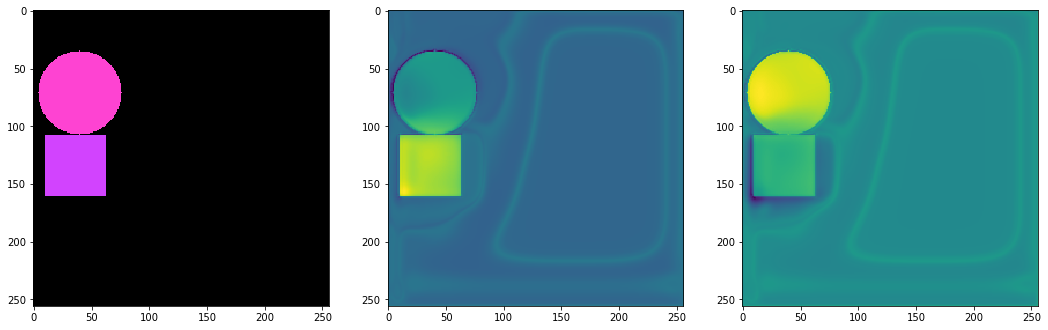

  0%|          | 1/200 [00:00<01:30,  2.20it/s]

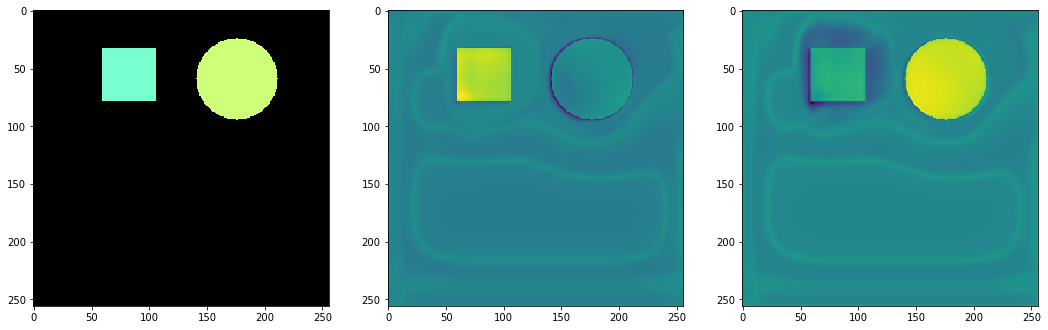

  1%|          | 2/200 [00:00<01:25,  2.31it/s]

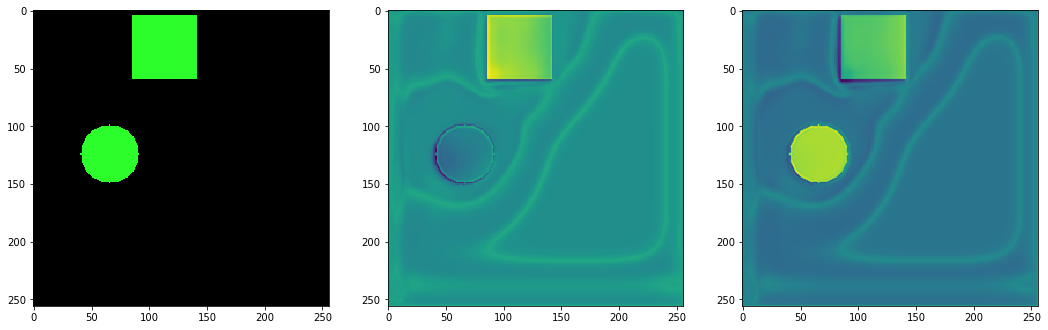

  2%|▏         | 3/200 [00:01<01:22,  2.39it/s]

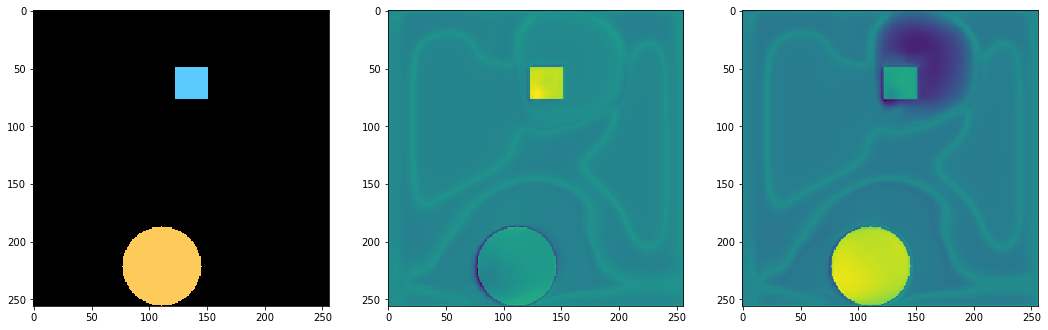

  2%|▏         | 4/200 [00:01<01:22,  2.36it/s]

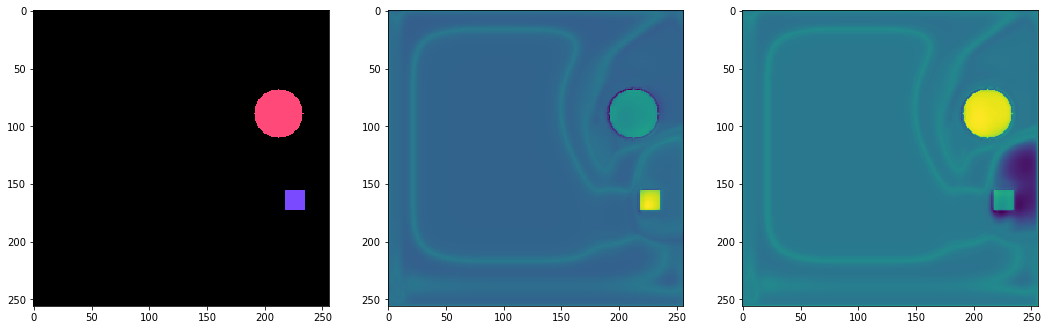

  2%|▎         | 5/200 [00:02<01:21,  2.40it/s]

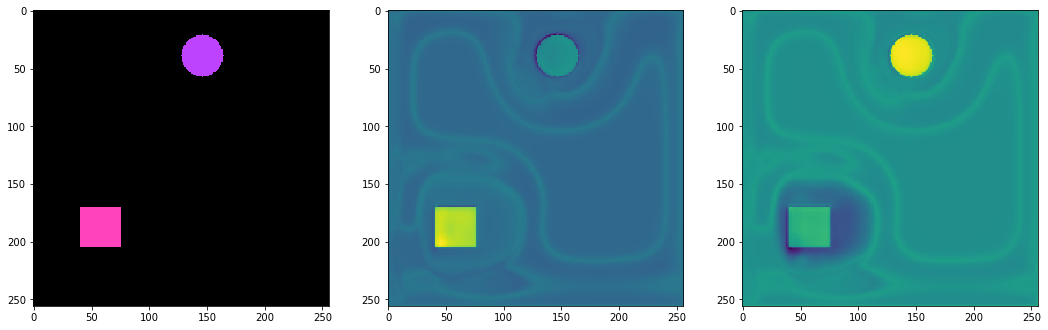

  3%|▎         | 6/200 [00:02<01:19,  2.44it/s]

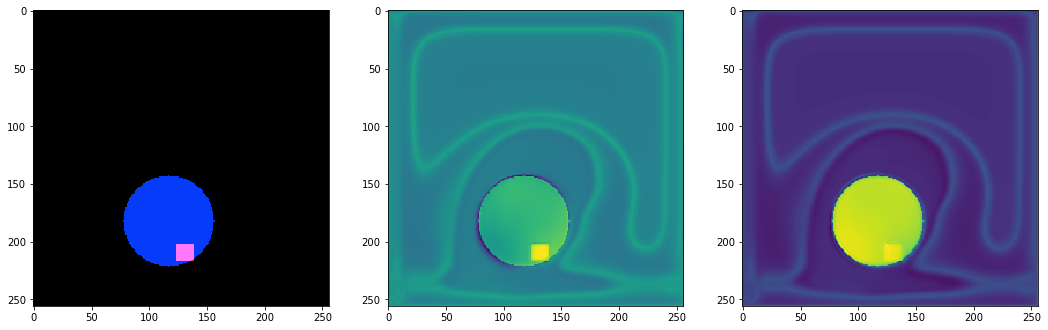

  4%|▎         | 7/200 [00:02<01:26,  2.24it/s]

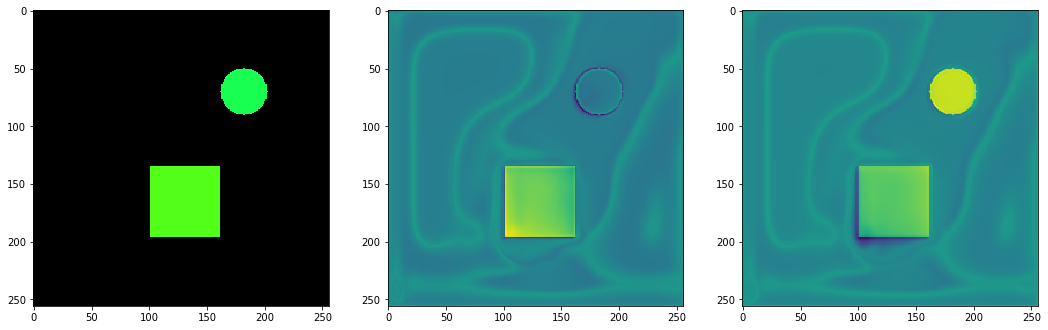

  4%|▍         | 8/200 [00:03<01:23,  2.30it/s]

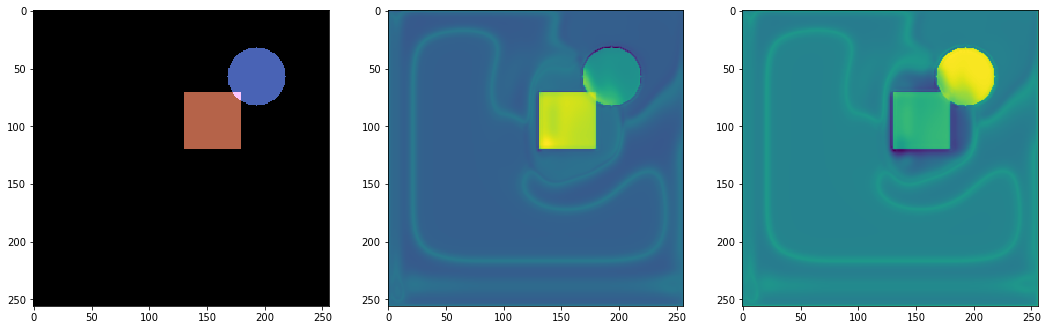

  4%|▍         | 9/200 [00:03<01:20,  2.36it/s]

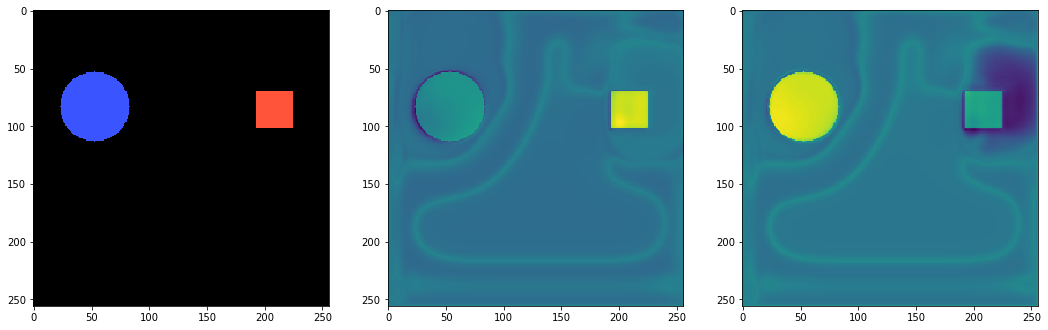

  5%|▌         | 10/200 [00:04<01:21,  2.32it/s]

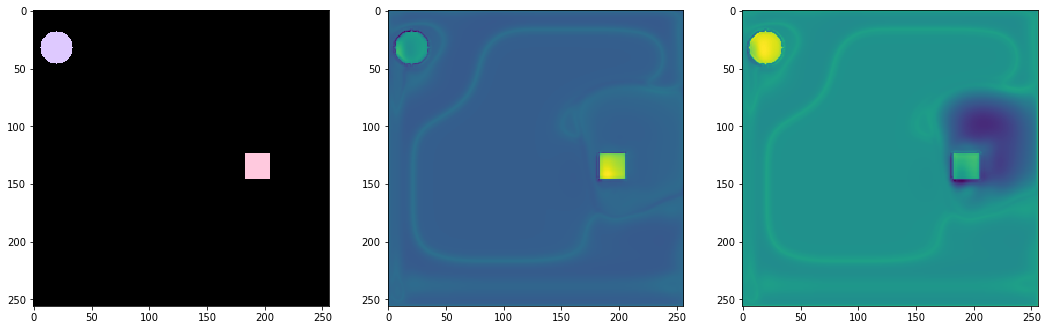

  6%|▌         | 11/200 [00:04<01:19,  2.38it/s]

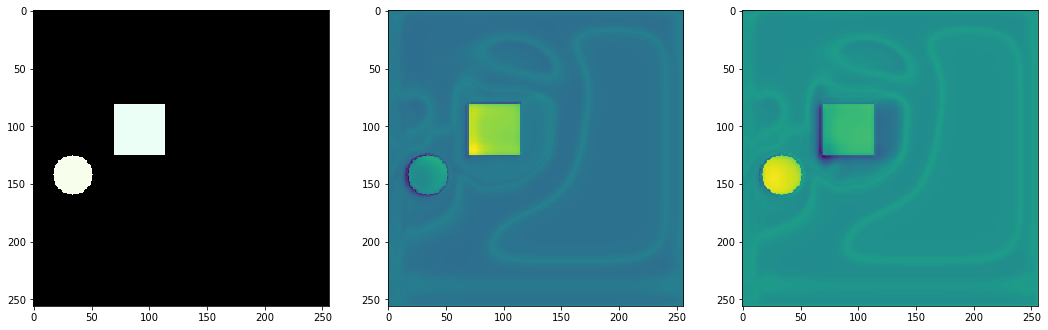

  6%|▌         | 12/200 [00:05<01:18,  2.39it/s]

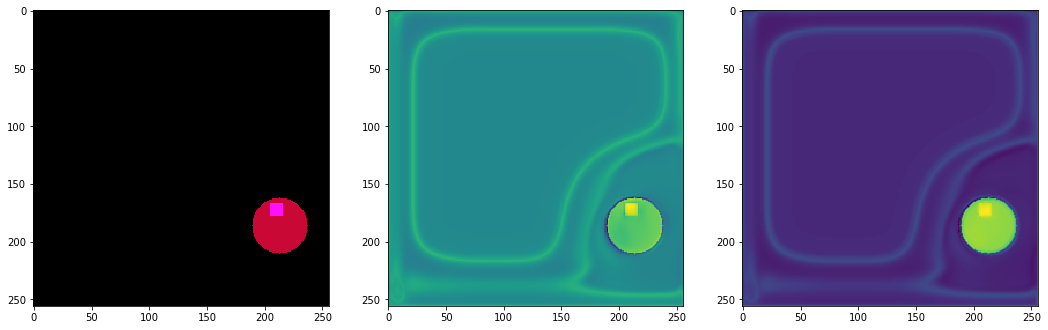

  6%|▋         | 13/200 [00:05<01:16,  2.44it/s]

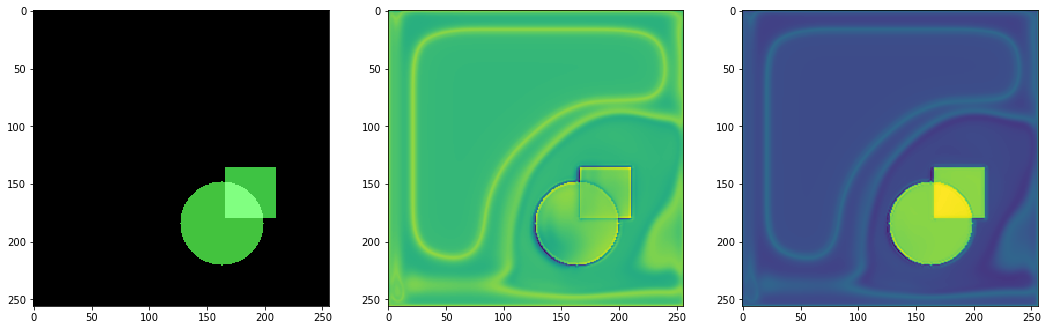

  7%|▋         | 14/200 [00:05<01:15,  2.46it/s]

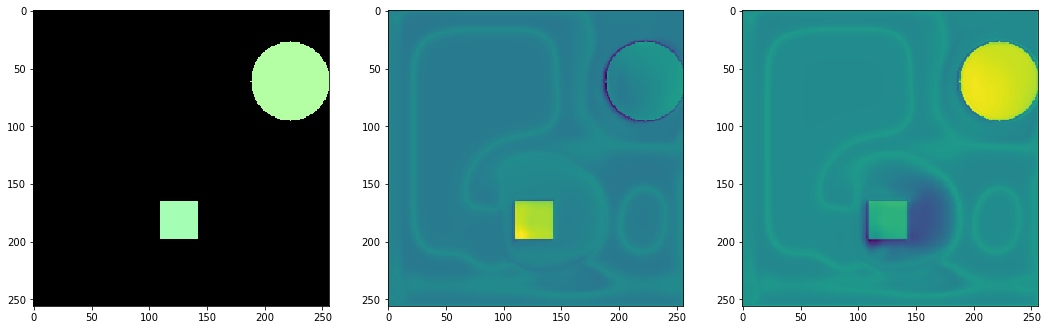

  8%|▊         | 15/200 [00:06<01:15,  2.46it/s]

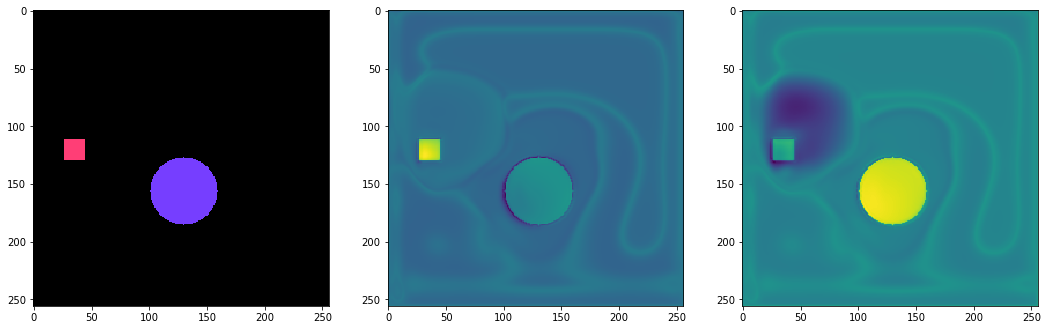

  8%|▊         | 16/200 [00:06<01:19,  2.33it/s]

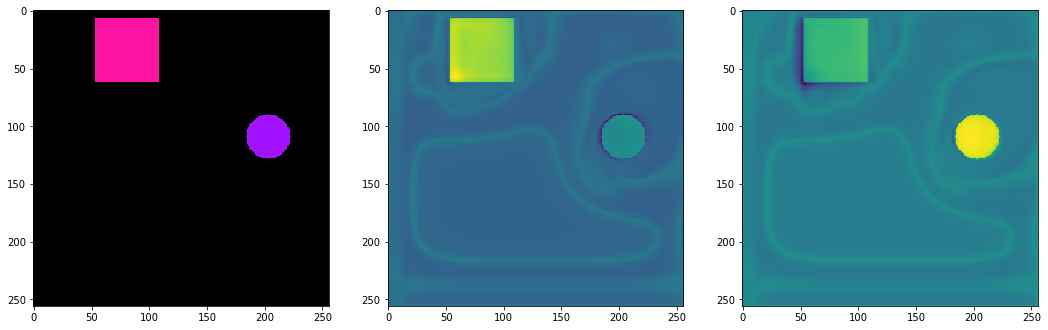

  8%|▊         | 17/200 [00:07<01:16,  2.39it/s]

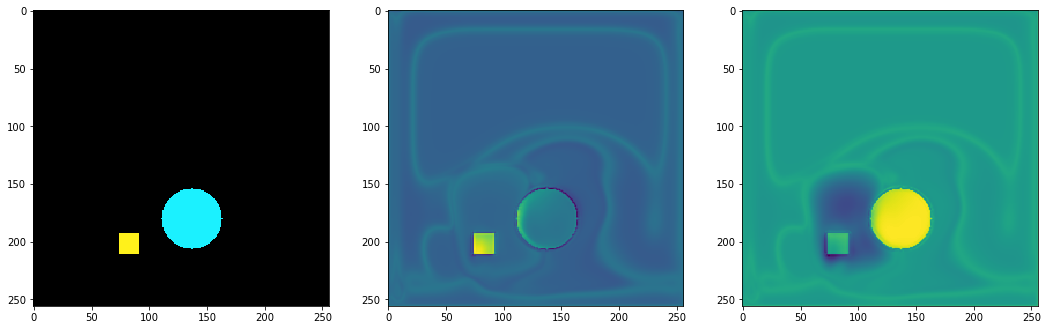

  9%|▉         | 18/200 [00:07<01:15,  2.40it/s]

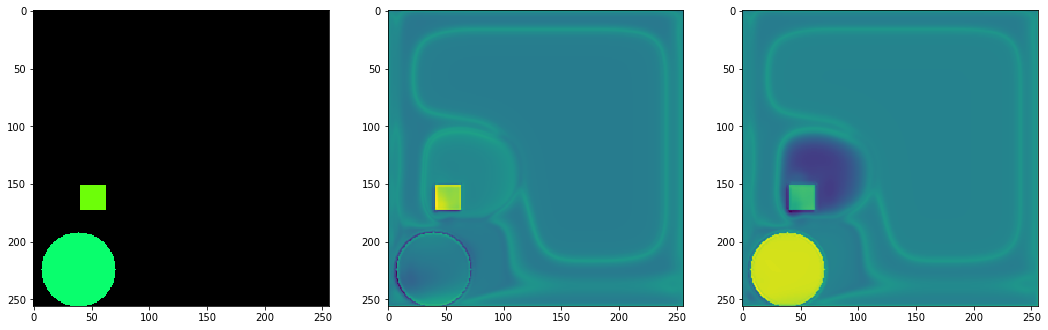

 10%|▉         | 19/200 [00:07<01:14,  2.43it/s]

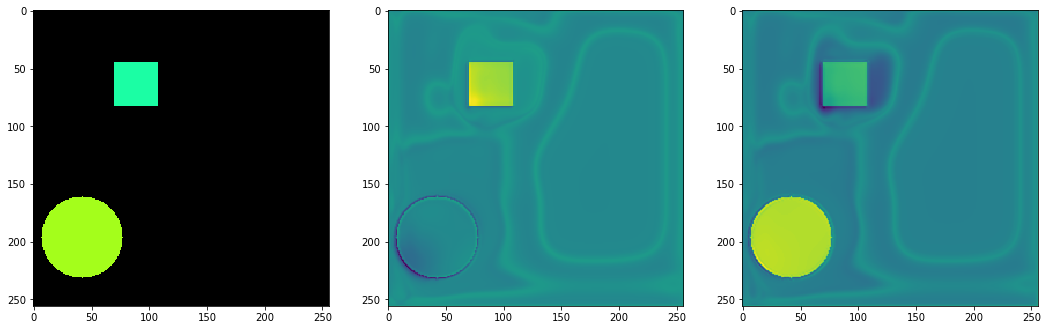

 10%|█         | 20/200 [00:08<01:16,  2.35it/s]

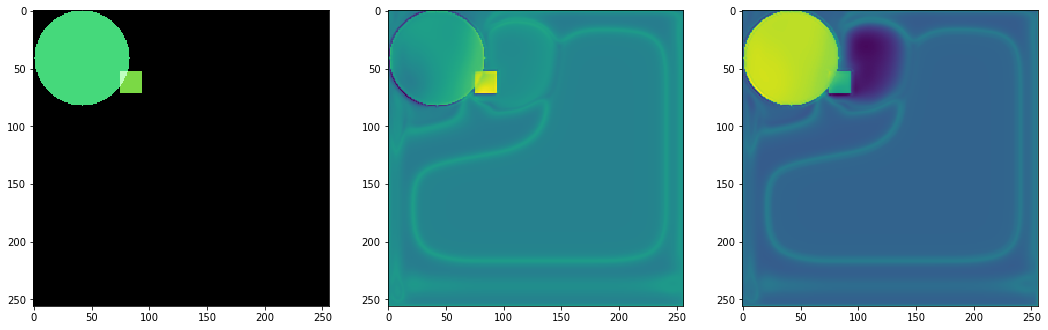

 10%|█         | 21/200 [00:08<01:14,  2.39it/s]

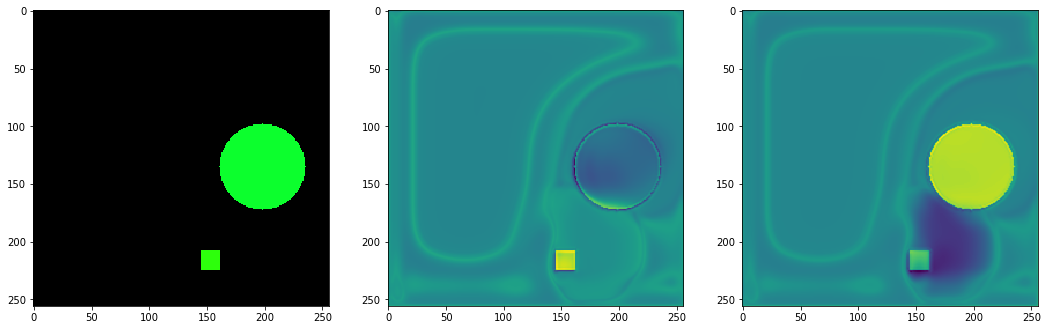

 10%|█         | 21/200 [00:09<01:18,  2.27it/s]


In [44]:
#evaluet results
unet_model.eval()
with torch.no_grad():
    for batch_idx,(img,mask_rect ,mask_circ) in enumerate (tqdm(eval_loader)):
        img = img.to(device)
        mask_rect = mask_rect.to(device)
        mask_circ = mask_circ.to(device)
        output = unet_model(img)
        
        output_num = output.data.cpu().numpy()
        output_bin = output_num[0]
        img = img[0]
        img = img.data.cpu().numpy()
        img = np.moveaxis(img, 0, -1)
        
        fig, axes = plt.subplots(1, 3, figsize=(18,18))
            
        #plt.figure(figsize=(18,18))
        #plt.subplot(311,)
        axes[0].imshow(img)
        #plt.subplot(321)
        axes[1].imshow(output_bin[0])
        #plt.subplot(331)
        axes[2].imshow(output_bin[1])
        
        plt.show()
        if batch_idx > 20:#we will test with 20images
                    break

# Conclussions

Image segmentation is a task that work well for convolution networks

# Regression task (Normalization  with max)

The function to regress is (x1 - x2) + (x3 * x3)

In [31]:
regression_df = pd.read_csv('./data/csv/regression.csv')
print(len(regression_df))
regression_df.head()


999


x1  x2  x3    y  class
0  -4  -6  -9   83      1
1   9   6  -1    4      1
2  -1 -10   3   18      1
3  -2  10   0  -12      0
4   1   0 -10  101      1

In [32]:
#clipping and normalization between -1,1
#clipp not required
#save max for each variables
nMax_data = regression_df.max()
regression_df.x1 = regression_df.x1/regression_df.x1.max()
regression_df.x2 = regression_df.x2/regression_df.x2.max()
regression_df.x3 = regression_df.x3/regression_df.x3.max()
regression_df.y = regression_df.y/regression_df.y.max()

In [33]:
features = ['x1','x2','x3']
x = regression_df[features]
y = regression_df.y
train_x,eval_x,train_y,eval_y = train_test_split(x,y,train_size = 0.8,random_state = 3)

In [34]:
torch.tensor(train_x.values).shape

torch.Size([799, 3])

In [35]:
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor,self).__init__()
        self.fc1 = nn.Linear(3,3)
        self.out = nn.Linear(3,1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x


        

In [40]:
def ovefititing_training(model,loss_function,optimizer,input_data,output_data,max_epochs=20):
    '''Train the model for one wimple input until overfit 
   the number of pass required will then the epochs(the time of passed for all the training set) '''
    running_loss = 0
    accuracy = 0
    input_indx = random.randint(0,len(input_data))
    for epoch in tqdm(range(max_epochs)):
        model.train()
        #get data
        input_tensor = torch.tensor(input_data.values[input_indx],dtype = torch.float32)#dataframe rec
        output_tensor = torch.tensor(output_data.values[input_indx],dtype = torch.float32)
        #move to device
        input_tensor = input_tensor.to(device)
        output_tensor =  output_tensor.to(device)
        output_tensor = output_tensor[None][None]#adjust to output size
        #clean gradients
        optimizer.zero_grad()
        prediction = model(input_tensor[None])#same as unsqueeze(input_tensor,x)
       # print(prediction.shape,prediction,output_tensor.shape,output_tensor)
        loss = loss_function(prediction,output_tensor)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('loss',running_loss)
          
    #model evaluation
    model.eval()
    with torch.no_grad():
        #get data
        input_tensor = torch.tensor(input_data.values[input_indx],dtype = torch.float32)#dataframe rec
        #output_tensor = torch.tensor(output_data.values[input_indx],dtype = torch.float32)
        #move to device
        input_tensor = input_tensor.to(device)
        prediction = model(input_tensor[None])#same as unzquezee 
        prediction_num = prediction.data.cpu().numpy()
        print('x:',input_data.values[input_indx],'y:',output_data.values[input_indx])
        print('Model output ý:',prediction_num*nMax_data.y, 'Expected output y :', output_data.values[input_indx]*nMax_data.y)
        
        
        
        
       


In [41]:
def train_model(model,loss_function,optimizer,input_data,output_data,max_epochs=20):
    '''Train for all the dataset without early stopping batch size 1'''
    running_loss = 0
    accuracy = 0
    data_len = len(input_data)
    for epoch in tqdm(range(max_epochs)):
        model.train()
        #running_loss = 0
        for indx in range(data_len):
            #get data
            input_tensor = torch.tensor(input_data.values[indx],dtype = torch.float32)#dataframe rec
            output_tensor = torch.tensor(output_data.values[indx],dtype = torch.float32)
            #move to device
            input_tensor = input_tensor.to(device)
            output_tensor =  output_tensor.to(device)
            output_tensor = output_tensor[None][None]#adjust to output size
            #clean gradients
            optimizer.zero_grad()
            prediction = model(input_tensor[None])#same as unsqueeze(input_tensor,x)
            
            loss = loss_function(prediction,output_tensor)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    print('epoch',epoch, 'running_loss',running_loss)
    #save the model
    torch.save(model.state_dict(), './model_zoo/regressor.pth')
    print('...model save')
      
    #model evaluation
def eval_model(model,input_data,output_data):
    model.eval()
    output_a =[] 
    data_len = len(input_data)
    with torch.no_grad():
        
        for indx in tqdm(range(data_len)):
            #get data
            input_tensor = torch.tensor(input_data.values[indx],dtype = torch.float32)#dataframe rec
            
            #output_tensor = torch.tensor(output_data.values[input_indx],dtype = torch.float32)
            #move to device
            input_tensor = input_tensor.to(device)
            output = model(input_tensor[None])#same as unzquezee
            #print(input_tensor,output,output_data.values[input_indx])
            output_num = output.data.cpu().numpy()   
            output_a.append(output_num.item())
    input_indx = random.randint(0,data_len)
    print('x:',input_data.values[input_indx],'y:',output_data.values[input_indx])
    print('Sample Model output ý:',output_a[input_indx]*nMax_data.y, 'Expected output y :', output_data.values[input_indx]*nMax_data.y)
    return np.array(output_a)

In [42]:
regressor = Regressor()
MSE_criterion = nn.MSELoss()
adam_optimizer = optim.Adam(regressor.parameters(), lr=0.001)
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regressor.to(device)

Regressor(
  (fc1): Linear(in_features=3, out_features=3, bias=True)
  (out): Linear(in_features=3, out_features=1, bias=True)
)

In [44]:
nEpochs = 1000
torch.cuda.empty_cache()
ovefititing_training(regressor,MSE_criterion,adam_optimizer,train_x,train_y,nEpochs)

100%|██████████| 1000/1000 [00:01<00:00, 846.40it/s]

loss 2.657318711544435
x: [0.4 0.4 0.7] y: 0.4152542372881356
Model output ý: [[48.99998]] Expected output y : 49.0


In [15]:
nEpochs = 500
torch.cuda.empty_cache()
train_model(regressor,MSE_criterion,adam_optimizer,train_x,train_y,nEpochs)

100%|██████████| 500/500 [07:19<00:00,  1.14it/s]

epoch 499 running_loss 20245274.869537972
...model save


In [16]:
torch.cuda.empty_cache()
predictions = eval_model(regressor,eval_x,eval_y)
eval_y_np = np.array(eval_y.values)
print(eval_y_np)
print(predictions)
d = np.abs(eval_y_np - predictions)
s = np.abs(eval_y_np) + np.abs(predictions)
print("mean difference",np.mean(d))

100%|██████████| 200/200 [00:00<00:00, 6208.08it/s]

x: [ -9   8 -10] y: 83
Sample Model output ý: 78.16974639892578 Expected output y : 83
[ 65  83  26  52  86  81 113  70  75  17  96  35  51   7 104  57  18  32
   6  -1 115  70  48  65  12  25   5  27   9  74  43  55  46  -4 111  43
  38  -1   4  10   7  17  62 103  11  75  51  41  -4  25 -10   6  39  11
  -8  57  41  21  14  14  -6  31  66  26  42  31  22  91   4   4   0  -7
  10  24  73  38  22  23  -5  20 105  49  84  43  36  90   1  -8  30  37
  14  11 109  90  69   5  22  10  14  33  30  57  60  -2  88  61  12  73
  74  17   9  51  21  32  28  27  82  80  81  86  13  22  26   3  -4  13
  -8  12  10  49  81 -16  13  14  -2  -1   2  24   8  14  15   9  63   9
  54  38  -6  -5 102  12  -5  34  18   4  92  18  -2  58  90   1  -8  20
  26  26  19  91  16   2  34  18  47  14  -1  47  26  69   0  -4 -12  97
  25   2  45  33  43  83  26  76  16  25   1  15   6  -8  84  29   4  83
  -2   3]
[ 6.75792084e+01  8.31334610e+01  2.10160236e+01  5.66577835e+01
  8.45114594e+01  8.13579636e+01  1